### 기본 라이브러리 import 및 data load( diabetes.csv)

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

from keras.regularizers import l1, l2

import pandas as pd

%matplotlib inline
rcParams['figure.figsize'] = 12, 10

diabetes = datasets.load_diabetes()

print(diabetes.data.shape) # data

X = diabetes.data

Y = diabetes.target

dir(diabetes)
print(diabetes.DESCR)


(442, 10)
.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more informatio

In [19]:
#Split data into train and test

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state=0)

print(x_train.shape)
print(x_test.shape)

print(x_test[0:4])

# Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).
# Normalization is not needed!!!


(309, 10)
(133, 10)
[[ 0.01991321  0.05068012  0.10480869  0.07007254 -0.03596778 -0.0266789
  -0.02499266 -0.00259226  0.00371174  0.04034337]
 [-0.01277963 -0.04464164  0.06061839  0.05285819  0.04796534  0.02937467
  -0.01762938  0.03430886  0.0702113   0.00720652]
 [ 0.03807591  0.05068012  0.00888341  0.04252958 -0.04284755 -0.02104223
  -0.03971921 -0.00259226 -0.01811827  0.00720652]
 [-0.01277963 -0.04464164 -0.02345095 -0.04009932 -0.01670444  0.00463594
  -0.01762938 -0.00259226 -0.03845911 -0.03835666]]


### Normalization된 data라서 별도의 feature normalization은 불 필요
### Model Building ( 2Layers MLP)
#### Layer 0와 1에 Regularization 추가 (별 도움은 없는 듯.)
#### Layer 수/Size등을 조정해 봐도 MAE에서 큰 이득이 없음.

In [20]:
# NN Parameters

def build_model():
  model = keras.Sequential([
      layers.Dense(8, activation=tf.nn.relu, input_shape=[10],activity_regularizer=l1(0.01)),
      layers.Dense(4, activation=tf.nn.relu,activity_regularizer=l2(0.01)),
      layers.Dense(1)
  ])

  #optimizer = tf.keras.optimizers.RMSprop(0.001)
  optimizer = tf.keras.optimizers.Adam(lr=0.01)
  model.compile(loss='mean_squared_error', optimizer=optimizer,
             metrics=['mean_absolute_error','mean_squared_error'])
  return model
                      
model = build_model()
                      
model.summary();

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


### Model Traning : 
### 기본은 1000 Epoch, early stop 조건을 넣었음.

In [21]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if  (epoch %100)==0: print ('')
    print('.', end='')
    
    
EPOCHS=1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train, epochs=EPOCHS, validation_split=0.1, verbose=0, batch_size=16,
                   callbacks=[early_stop, PrintDot()])


....................................................................................................
............................

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
123,2811.609927,42.889847,2797.223633,2969.834040,45.241573,2954.473389,123
124,2822.392099,43.005604,2807.878418,2958.990376,45.218929,2943.581543,124
125,2816.738741,42.979603,2802.469727,2966.008561,45.157509,2950.695801,125
126,2823.324911,43.014931,2808.882080,2957.610383,45.275043,2942.173340,126
127,2821.897621,42.963470,2807.489014,2963.087639,45.118942,2947.784668,127


### MAE와 MSE 를 Train Error 및 VAL Error에 대해 그려봄.
### Train Error와 Val Error 차이 적은 것으로 보아, Overfitting은 아닌 것으로 보임
###  MAE 자체가 높은 것으로 보아, Bias Error가 큰 것으로 보이는데, 관련하여 모델 변경, 파라미터 변경 등을 해 보았는데 이득이 거의 없음. (데이터가 부족한 것으로 판단됨)

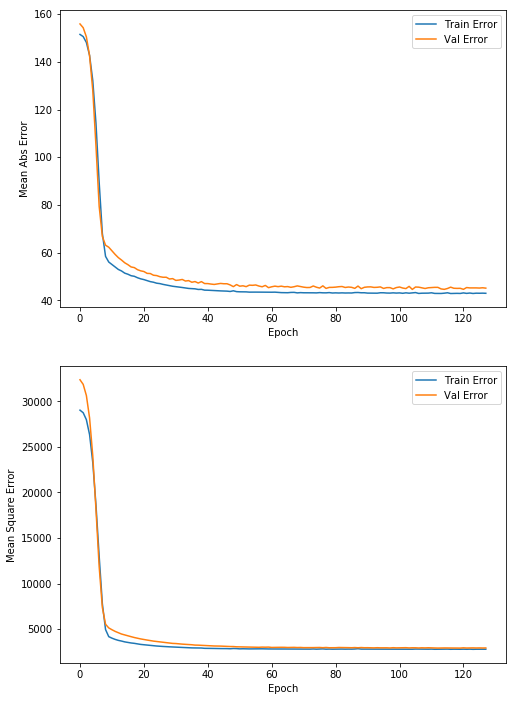

In [23]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.show()

plot_history(history)
  

### Test Accuracy using test set
#### 1년 후 측정한 당뇨병의 진행률 예측 결과.. 대략 44~50% 수준의 MAE 를 보임.
#### (Regularization, Optimzer 변경, activation function(sigmoid, Relu) 변경해도 큰차이 없음)
#### Predicted Value와 True Value를 그려 보았을 때, 직선에서 꽤 많이 벗어는 형태의 결과를 보임. 
#### 큰 틀에서의 방향성은 조금 보이지만, 예측 값의 신뢰 수준은 낮은 듯함.

No handles with labels found to put in legend.


Absolute Error using Test Set. : 44.59
MSE using Test Set. : 3096.72


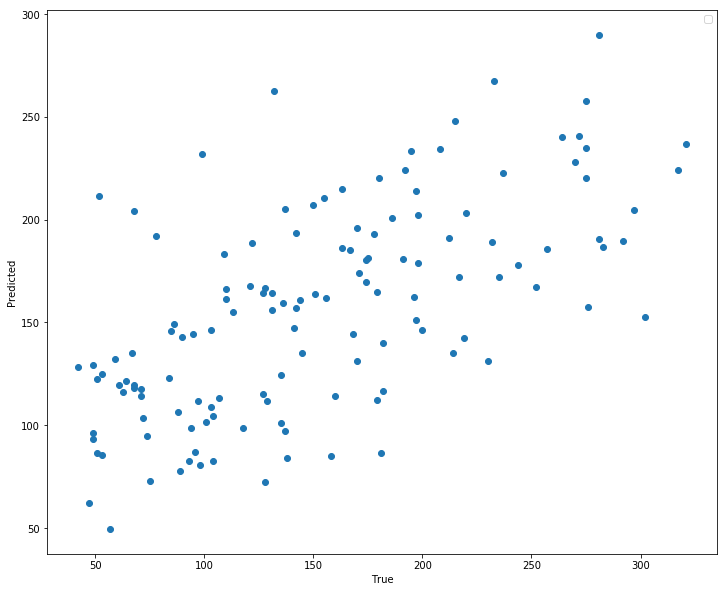

In [24]:
loss, mae, mse = model.evaluate(x_test, y_test, verbose=0)
print('Absolute Error using Test Set. : %5.2f'%(mae))
print('MSE using Test Set. : %5.2f'%(mse))
y_predict = model.predict(x_test)
#for true_val, pred_val in zip(y_test, y_predict):
#  print("%f, %f  diff=(%f)"%(true_val, pred_val, (true_val-pred_val)))
#diff = np.abs( (y_test - y_predict)/y_test)
#diff.mean()
#plt.plot(y_predict,'xb',label='predicted')
#plt.plot(y_test,'*r', label ='True')
plt.scatter(y_test,y_predict)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()
plt.show()